In [33]:
# import packages
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import distance
from scipy.stats import mode
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
Data type is: float64
Shap is: (1797, 64)
5


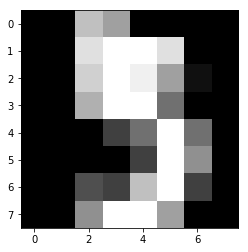

In [5]:
digits = load_digits()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

print('Data type is: ' + str(data.dtype))
print('Shap is: ' + str(data.shape))

img_number = 5
print(target_names[img_number])
img_shape = [8, 8]

img = images[img_number]  # np.reshape(data[img_number],img_shape)

# test dimensionality
assert 2 == np.size(np.shape(img))

plt.figure()
plt.gray()
plt.imshow(img, interpolation="nearest")
plt.show()

X_all = data
y_all = target

# this is deprecated
# X_train, X_test, y_train, y_test = cross_validation.train_test_split(digits.data, digits.target, test_size = 0.4, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.4, random_state=0)


In [6]:
# that's an incredible loopy function
def dist_loop(training_set, test_set):
    # train_shape = training
    dist = np.zeros((training_set.shape[0], test_set.shape[0]))
    for i in range(training_set.shape[0]):
        for j in range(test_set.shape[0]):
            dist[i, j] = np.sqrt(np.sum(np.square(test_set[j,k]-training_set[i,k]) for k in range(training_set.shape[1])))
    return dist

In [10]:
def dist_mat(training_set, test_set):
    dist = distance.cdist(training_set, test_set, metric="euclidean")
    return dist

In [12]:
t = time.process_time()
dist1 = dist_loop(X_train, X_test)
elapsed_time = time.process_time() - t
print("Elapsed time for loopy function was " + str(elapsed_time))

t = time.process_time()
dist2 = dist_mat(X_train, X_test)
elapsed_time = time.process_time() - t
print("Elapsed time for matrix function was " + str(elapsed_time))


# check equality of both functions
eps = 1e-5
abs_diff = np.abs(dist1 - dist2)
assert abs_diff.all() < eps

Elapsed time for loopy function was 115.453125
Elapsed time for matrix function was 0.046875


In [14]:
# implementation of nearest neighbour classifier
dist = dist2


In [29]:

# only use 3 and 9
n1 = 3
n2 = 9
sub_ix = np.where((y_train == n1) | (y_train == n2))
y_train_sub = y_train[sub_ix]
X_train_sub = (X_train[sub_ix,:]).squeeze()

sub_ix = np.where((y_test == n1) | (y_test == n2))
y_test_sub = y_test[sub_ix]
X_test_sub = (X_test[sub_ix,:]).squeeze()

def nearest_neighbour(xt, x, yt): # x: new data, xt: trained data yt: trained target
    dist = dist_mat(xt, x) # rows are xt, columns x, so find argmin in one column
    argmin_dist = np.argmin(dist, 0)
    y = yt[argmin_dist]
    return y

def calc_true_pred(y_p, y_t):
    is_true = np.zeros_like(y_t)
    is_true[(y_p == y_t)] = 1
    no_true = np.sum(is_true)
    perc_true = no_true / len(y_p)
    return no_true, perc_true

y_pNN = nearest_neighbour(X_train_sub, X_test_sub, y_train_sub)
_, percent_true_1NN = calc_true_pred(y_pNN, y_test_sub)
print(percent_true_1NN)

0.986111111111


In [32]:
def k_nearest_neighbour(xt, x, yt, k):
    dist = dist_mat(xt, x)  # rows are xt, columns x, so find argmin in one column
    argmin_dist = np.argsort(dist, 0)
    y_argmin_dist = yt[argmin_dist[:k,:]] #[argmin_dist,k]
    # find most common value and output that as majority vote /// tbd
    majority_information = mode(y_argmin_dist, axis=0)
    return np.squeeze(majority_information.mode)

k_tests = [1, 3, 5, 9, 17, 33]
for k in k_tests:
    y_pkNN = k_nearest_neighbour(X_train_sub, X_test_sub, y_train_sub, k)
    _, percent_true_kNN = calc_true_pred(y_pkNN, y_test_sub)
    print('k: ' + str(k) + ' success: ' + str(percent_true_kNN))

k: 1 success: 0.986111111111
k: 3 success: 0.993055555556
k: 5 success: 0.993055555556
k: 9 success: 0.993055555556
k: 17 success: 0.993055555556
k: 33 success: 0.979166666667


In [45]:
def cross_validation(x,y,k,folds):
    len_data = len(y)
    fold_size = np.floor(len_data / folds)

    percent_true_sk_kNN = np.zeros((folds,1))
    percent_true_own_kNN = np.zeros((folds,1))
    for i in range(folds):
        ix_test = list(range(int(i * fold_size), int((i + 1) * fold_size)))
        ix_train = list(range(len_data))
        del ix_train[int(i * fold_size):int((i + 1) * fold_size)]

        xs_train = x[ix_train]
        xs_test = x[ix_test]

        ys_train = y[ix_train]
        ys_test = y[ix_test]

        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(xs_train, ys_train)
        result_sk_classifier = neigh.predict(xs_test)
        
        result_own_classifier = k_nearest_neighbour(xs_train,xs_test,ys_train, k)
        
        _, percent_true_sk_kNN[i] = calc_true_pred(result_sk_classifier, ys_test)
        _, percent_true_own_kNN[i] = calc_true_pred(result_own_classifier, ys_test)
        # print(percent_true_kNN[i])
    # mean_perc = np.mean(percent_true_kNN)
    print('k: ' + str(k) + ' --- n: ' + str(folds) + ' --- mean success: ' + str(np.mean(percent_true_sk_kNN)) + ' sk class.')
    print('k: ' + str(k) + ' --- n: ' + str(folds) + ' --- mean success: ' + str(np.mean(percent_true_own_kNN)) + ' own class.')



In [46]:
folds = [2, 5, 10]
for k in k_tests:
    for n in folds:
        cross_validation(digits.data, digits.target, k, n)

k: 1 --- n: 2 --- mean success: 0.95991091314 sk class.
k: 1 --- n: 2 --- mean success: 0.959354120267 own class.


k: 1 --- n: 5 --- mean success: 0.964902506964 sk class.
k: 1 --- n: 5 --- mean success: 0.964902506964 own class.


k: 1 --- n: 10 --- mean success: 0.975418994413 sk class.
k: 1 --- n: 10 --- mean success: 0.975418994413 own class.


k: 3 --- n: 2 --- mean success: 0.957683741648 sk class.
k: 3 --- n: 2 --- mean success: 0.957683741648 own class.


k: 3 --- n: 5 --- mean success: 0.966573816156 sk class.
k: 3 --- n: 5 --- mean success: 0.966573816156 own class.


k: 3 --- n: 10 --- mean success: 0.975977653631 sk class.
k: 3 --- n: 10 --- mean success: 0.975977653631 own class.


k: 5 --- n: 2 --- mean success: 0.951559020045 sk class.
k: 5 --- n: 2 --- mean success: 0.951559020045 own class.


k: 5 --- n: 5 --- mean success: 0.964902506964 sk class.
k: 5 --- n: 5 --- mean success: 0.965459610028 own class.


k: 5 --- n: 10 --- mean success: 0.973184357542 sk class.
k: 5 --- n: 10 --- mean success: 0.973184357542 own class.


k: 9 --- n: 2 --- mean success: 0.944320712695 sk class.
k: 9 --- n: 2 --- mean success: 0.944320712695 own class.


k: 9 --- n: 5 --- mean success: 0.957660167131 sk class.
k: 9 --- n: 5 --- mean success: 0.957660167131 own class.


k: 9 --- n: 10 --- mean success: 0.967039106145 sk class.
k: 9 --- n: 10 --- mean success: 0.967039106145 own class.


k: 17 --- n: 2 --- mean success: 0.938195991091 sk class.
k: 17 --- n: 2 --- mean success: 0.937639198218 own class.


k: 17 --- n: 5 --- mean success: 0.955431754875 sk class.
k: 17 --- n: 5 --- mean success: 0.955431754875 own class.


k: 17 --- n: 10 --- mean success: 0.964804469274 sk class.
k: 17 --- n: 10 --- mean success: 0.964804469274 own class.


k: 33 --- n: 2 --- mean success: 0.9214922049 sk class.
k: 33 --- n: 2 --- mean success: 0.922048997773 own class.


k: 33 --- n: 5 --- mean success: 0.940389972145 sk class.
k: 33 --- n: 5 --- mean success: 0.940947075209 own class.


k: 33 --- n: 10 --- mean success: 0.94748603352 sk class.
k: 33 --- n: 10 --- mean success: 0.948044692737 own class.
